In [1]:
%matplotlib inline


from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import os
import numpy as np
import pandas as pd
import glob
import json
import scipy as sp
import pdb
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits

from myutils import *

In [2]:
from lsst.obs.lsst import LsstCam
camera = LsstCam.getCamera()
det_names = {i: det.getName() for i, det in enumerate(camera)}
det_ptypes = {i: det.getPhysicalType() for i, det in enumerate(camera)}
det_nums = {det.getName():i for i, det in enumerate(camera)}

# Get Single Raft QE data

In [3]:
goodruns = get_goodruns(loc='slac',useold=False)
rtmids = get_rtmids()
baytype = get_rtmtype()

## revise missing/bad data...

1. R30_S00 has no data, see /gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-012/11063/qe_raft_analysis/v0/85826/S00 problem is the one dead channel has nan's - fixed in code
2. R32_S11 has values at 1000 or so, and the Run 11063 only has a small number of wavelengths too.  Is there a better run to use? Use BNL Run 7678, with file in: /nfs/farm/g/lsst/u1/mirror/BNL-prod/prod/LCA-11021_RTM/LCA-11021_RTM-015/7678/qe_raft_analysis/v0/50602/S00/E2V-CCD250-293_QE.fits.  See: https://confluence.slac.stanford.edu/display/LSSTCAM/Useful+TS8+runs for the runs that exist from BNL data

In [4]:
print(goodruns)
print(rtmids)
print(baytype)


# modify goodrun for RTM-015 to use the BNL D run 7678
goodruns['RTM-015'] = '7678'

# modify goodruns for these, to use BNL D runs with more wavelengths, since I&T good run has only 6 or 7 points
goodruns['RTM-020'] = '9442'
goodruns['RTM-017'] = '8872'
goodruns['RTM-025'] = '10238'

{'RTM-004': '11977', 'RTM-005': '11852', 'RTM-006': '11746', 'RTM-007': '11903', 'RTM-008': '11952', 'RTM-009': '11415', 'RTM-010': '12139', 'RTM-011': '10861', 'RTM-012': '11063', 'RTM-013': '10982', 'RTM-014': '10928', 'RTM-015': '12002', 'RTM-016': '12027', 'RTM-017': '11166', 'RTM-018': '12120', 'RTM-019': '11808', 'RTM-020': '10669', 'RTM-021': '12086', 'RTM-022': '11671', 'RTM-023': '10517', 'RTM-024': '11351', 'RTM-025': '10722', 'CRTM-0002': '6611D', 'CRTM-0003': '10909', 'CRTM-0004': '11128', 'CRTM-0005': '11260'}
{'R00': 'CRTM-0002', 'R40': 'CRTM-0003', 'R04': 'CRTM-0004', 'R44': 'CRTM-0005', 'R10': 'RTM-023', 'R20': 'RTM-014', 'R30': 'RTM-012', 'R01': 'RTM-011', 'R11': 'RTM-020', 'R21': 'RTM-025', 'R31': 'RTM-007', 'R41': 'RTM-021', 'R02': 'RTM-013', 'R12': 'RTM-009', 'R22': 'RTM-024', 'R32': 'RTM-015', 'R42': 'RTM-018', 'R03': 'RTM-017', 'R13': 'RTM-019', 'R23': 'RTM-005', 'R33': 'RTM-010', 'R43': 'RTM-022', 'R14': 'RTM-006', 'R24': 'RTM-016', 'R34': 'RTM-008'}
{'R01': 'itl

In [23]:
def getQEFile(raft,slot,run):
    
    disk = 'fs1'
    raftdir = '/gpfs/slac/lsst/%s/g/data/jobHarness/jh_archive/LCA-11021_RTM/' % (disk)
    qedir = 'LCA-11021_%s/%s/qe_raft_analysis/v0/*/%s/' % (raft,run,slot)
    files = glob.glob(raftdir+qedir+'*.fits')
    
    if len(files)==0:
        disk = 'fs3'
        raftdir = '/gpfs/slac/lsst/%s/g/data/jobHarness/jh_archive/LCA-11021_RTM/' % (disk)
        files = glob.glob(raftdir+qedir+'*.fits')
        
        if len(files)==0:
            raftdir = '/nfs/farm/g/lsst/u1/mirror/BNL-prod/prod/LCA-11021_RTM/'
            files = glob.glob(raftdir+qedir+'*.fits')
        
    return files

def getFitsFile(raft,slot,run):
    
    disk = 'fs1'
    raftdir = '/gpfs/slac/lsst/%s/g/data/jobHarness/jh_archive/LCA-11021_RTM/' % (disk)
    qedir = 'LCA-11021_%s/%s/qe_raft_acq/v0/*/%s/' % (raft,run,slot)
    files = glob.glob(raftdir+qedir+'*_lambda_flat*.fits')
    
    if len(files)==0:
        disk = 'fs3'
        raftdir = '/gpfs/slac/lsst/%s/g/data/jobHarness/jh_archive/LCA-11021_RTM/' % (disk)
        files = glob.glob(raftdir+qedir+'*_lambda_flat*.fits')
        
        if len(files)==0:
            raftdir = '/nfs/farm/g/lsst/u1/mirror/BNL-prod/prod/LCA-11021_RTM/'
            files = glob.glob(raftdir+qedir+'*_lambda_flat*.fits')
        
    return sorted(files)
    

def getQE(raft,bay,run):
    
    wll = []
    qel = []
    templ = []
    slotl = []
    bayl = []
    rtypel = []
    bayslotl = []
    idetl = []
    
    slots = get_slots()

    for slot in slots:
        files = getQEFile(raft,slot,run)        
        flat_files = getFitsFile(raft,slot,run)
        
        if len(files)==1:
            
            hdu = fits.open(files[0]) 
            data = hdu[1].data
            
            nlam = len(data)
            print(bay,slot,nlam)
            wl_arr = np.zeros((nlam))
            qe_arr = np.zeros((nlam))
            ccdtemp_arr = np.zeros((nlam))
            for alam in range(nlam):
                wl = data[alam][0]
                qeval = data[alam][-1]  # has 16 amp values, then average last
                
                if np.isnan(qeval):
                    # get the 16 values and take the mean filtering the nans
                    qarr = data[alam][1:16+1]
                    qeval = np.nanmean(qarr)
                
                wl_arr[alam] = wl
                qe_arr[alam] = qeval
                
                # get CCDtemp too  - files should be in the same increasing order as the wavelengths
                hdu = fits.open(flat_files[alam])
                ccdtemp_arr[alam] = hdu[0].header['CCDTEMP']
                
        
            wll.append(wl_arr)
            qel.append(qe_arr)
            templ.append(ccdtemp_arr)
            slotl.append(slot)
            bayl.append(bay)
            rtypel.append(baytype[bay])
            bayslot = bay+"_"+slot
            bayslotl.append(bayslot)
            idetl.append(det_nums[bayslot])
        
    dd = {}
    dd['idet'] = idetl
    dd['bayslot'] = bayslotl
    dd['wl'] = wll
    dd['qe'] = qel
    dd['ccdtemp'] = templ
    dd['slot'] = slotl
    dd['bay'] = bayl
    dd['type'] = rtypel
    
    df = pd.DataFrame(dd)
    return df

In [54]:
flat_files = getFitsFile('RTM-015','S11',7678)
flat_files = getFitsFile('RTM-016','S11',12027)


for alam in range(len(flat_files)):
    hdu = fits.open(flat_files[alam])
    #print(alam,hdu[0].header['CCDTEMP'],hdu[18].header['R1CCDT1'])  #BNL data has this
    print(alam,hdu[0].header['CCDTEMP'],hdu[0].header['TEMP_SET'],hdu[0].header['DATE-OBS'])  #SLAC data has this

0 -101.796930487 -100.0 2019-11-10T22:20:56.802
1 -101.796930487 -100.0 2019-11-10T22:25:21.679
2 -101.796930487 -100.0 2019-11-10T22:28:11.910
3 -101.796930487 -100.0 2019-11-10T22:29:51.235
4 -101.796930487 -100.0 2019-11-10T22:31:04.577
5 -101.796930487 -100.0 2019-11-10T22:32:07.854
6 -101.796930487 -100.0 2019-11-10T22:33:06.407
7 -101.796930487 -100.0 2019-11-10T22:34:00.828
8 -101.796930487 -100.0 2019-11-10T22:34:58.075
9 -101.796930487 -100.0 2019-11-10T22:35:55.823
10 -101.796930487 -100.0 2019-11-10T22:36:51.421
11 -101.796930487 -100.0 2019-11-10T22:37:49.330
12 -101.796930487 -100.0 2019-11-10T22:38:47.584
13 -101.796930487 -100.0 2019-11-10T22:39:45.338
14 -101.796930487 -100.0 2019-11-10T22:40:43.908
15 -101.796930487 -100.0 2019-11-10T22:41:43.481
16 -101.796930487 -100.0 2019-11-10T22:42:44.142
17 -101.796930487 -100.0 2019-11-10T22:43:50.897
18 -101.796930487 -100.0 2019-11-10T22:44:59.406
19 -101.796930487 -100.0 2019-11-10T22:46:09.807
20 -101.796930487 -100.0 2019-

## get all bays

In [25]:
dfs = []
for bay in baytype.keys():
    
    print(bay)
    raft = rtmids[bay]
    run = goodruns[raft]
    
    dfs.append(getQE(raft,bay,run))
    
dfall = pd.concat(dfs)
dfall.set_index('idet')
    

R01
R01 S00 36
R01 S01 36
R01 S02 36
R01 S10 36
R01 S11 36
R01 S12 36
R01 S20 36
R01 S21 36
R01 S22 36
R02
R02 S00 36
R02 S01 36
R02 S02 36
R02 S10 36
R02 S11 36
R02 S12 36
R02 S20 36
R02 S21 36
R02 S22 36
R03
R03 S00 30
R03 S01 30
R03 S02 30
R03 S10 30
R03 S11 30
R03 S12 30
R03 S20 30
R03 S21 30
R03 S22 30
R10
R10 S00 36
R10 S01 36
R10 S02 36
R10 S10 36
R10 S11 36
R10 S12 36
R10 S20 36
R10 S21 36
R10 S22 36
R11
R11 S00 30
R11 S01 30
R11 S02 30
R11 S10 30
R11 S11 30
R11 S12 30
R11 S20 30
R11 S21 30
R11 S22 30
R12
R12 S00 36
R12 S01 36
R12 S02 36
R12 S10 36
R12 S11 36
R12 S12 36
R12 S20 36
R12 S21 36
R12 S22 36
R13
R13 S00 36
R13 S01 36
R13 S02 36
R13 S10 36
R13 S11 36
R13 S12 36
R13 S20 36
R13 S21 36
R13 S22 36
R14
R14 S00 36
R14 S01 36
R14 S02 36
R14 S10 36
R14 S11 36
R14 S12 36
R14 S20 36
R14 S21 36
R14 S22 36
R20
R20 S00 36
R20 S01 36
R20 S02 36
R20 S10 36
R20 S11 36
R20 S12 36
R20 S20 36
R20 S21 36
R20 S22 36
R21
R21 S00 30
R21 S01 30
R21 S02 30
R21 S10 30
R21 S11 30
R21 S12 30
R21

,bayslot,wl,qe,ccdtemp,slot,bay,type
idet,,,,,,,
0,R01_S00,"[319.9939880371094, 324.968994140625, 349.9819...","[48.62901306152344, 50.684478759765625, 61.073...","[-99.8364795338, -99.8364795338, -99.836479533...",S00,R01,itl
1,R01_S01,"[319.9939880371094, 324.968994140625, 349.9819...","[43.776634216308594, 44.711612701416016, 51.11...","[-99.3151788588, -99.3151788588, -99.315178858...",S01,R01,itl
2,R01_S02,"[319.9939880371094, 324.968994140625, 349.9819...","[49.37493896484375, 51.3961181640625, 61.52243...","[-99.7938428606, -99.7938428606, -99.793842860...",S02,R01,itl
3,R01_S10,"[319.9939880371094, 324.968994140625, 349.9819...","[49.03248977661133, 51.226158142089844, 62.138...","[-100.413607312, -100.413607312, -100.41360731...",S10,R01,itl
4,R01_S11,"[319.9939880371094, 324.968994140625, 349.9819...","[50.25616455078125, 52.671043395996094, 64.050...","[-100.871278094, -100.871278094, -100.87127809...",S11,R01,itl
...,...,...,...,...,...,...,...
184,R43_S11,"[319.9939880371094, 324.968994140625, 349.9819...","[51.537864685058594, 53.83469009399414, 65.350...","[-103.33417298, -103.33417298, -103.33417298, ...",S11,R43,itl
185,R43_S12,"[319.9939880371094, 324.968994140625, 349.9819...","[50.58000183105469, 52.9389533996582, 64.50895...","[-101.210327892, -101.210327892, -101.21032789...",S12,R43,itl
186,R43_S20,"[319.9939880371094, 324.968994140625, 349.9819...","[64.72469329833984, 67.41368103027344, 74.7405...","[-104.084448381, -104.084448381, -104.08444838...",S20,R43,itl


In [26]:
print(dfall)

    idet  bayslot                                                 wl  \
0      0  R01_S00  [319.9939880371094, 324.968994140625, 349.9819...   
1      1  R01_S01  [319.9939880371094, 324.968994140625, 349.9819...   
2      2  R01_S02  [319.9939880371094, 324.968994140625, 349.9819...   
3      3  R01_S10  [319.9939880371094, 324.968994140625, 349.9819...   
4      4  R01_S11  [319.9939880371094, 324.968994140625, 349.9819...   
..   ...      ...                                                ...   
4    184  R43_S11  [319.9939880371094, 324.968994140625, 349.9819...   
5    185  R43_S12  [319.9939880371094, 324.968994140625, 349.9819...   
6    186  R43_S20  [319.9939880371094, 324.968994140625, 349.9819...   
7    187  R43_S21  [319.9939880371094, 324.968994140625, 349.9819...   
8    188  R43_S22  [319.9939880371094, 324.968994140625, 349.9819...   

                                                   qe  \
0   [48.62901306152344, 50.684478759765625, 61.073...   
1   [43.7766342163085

In [27]:
dfall.to_parquet('qe_raft_values_20230706.parquet')

In [28]:
dfall['wl'].iloc[1]

array([ 319.99398804,  324.96899414,  349.98199463,  374.9750061 ,
        400.01901245,  424.96499634,  450.03500366,  475.00299072,
        500.01800537,  525.00201416,  550.0289917 ,  575.02301025,
        599.98199463,  619.99700928,  624.97900391,  650.01202393,
        675.00402832,  700.0300293 ,  725.01202393,  750.02197266,
        774.98699951,  799.97601318,  824.98797607,  850.02197266,
        869.96697998,  875.00201416,  899.99902344,  919.99902344,
        925.01202393,  949.96502686,  975.00201416,  999.97601318,
       1025.0279541 , 1050.01403809, 1075.00195312, 1099.98999023])

In [29]:
dfall['qe'].iloc[1]

array([43.77663422, 44.7116127 , 51.11926651, 66.39103699, 79.83794403,
       82.80201721, 82.57165527, 81.98149872, 81.54522705, 81.62437439,
       82.42385101, 83.38121033, 84.86004639, 85.42469788, 85.69808197,
       86.86910248, 87.98226166, 88.88550568, 89.7671814 , 91.30698395,
       92.75657654, 93.21575165, 92.77223969, 92.03578186, 90.0843277 ,
       89.31837463, 82.98152924, 75.07635498, 72.43457031, 59.28147507,
       44.81829453, 29.2123661 , 14.48572159,  5.82538462,  3.24378133,
        2.20794654])

In [52]:
# SLAC single raft data looks to have an issue - all files report the same temperature
dfall['ccdtemp'].iloc[1]

array([-99.31517886, -99.31517886, -99.31517886, -99.31517886,
       -99.31517886, -99.31517886, -99.31517886, -99.31517886,
       -99.31517886, -99.31517886, -99.31517886, -99.31517886,
       -99.31517886, -99.31517886, -99.31517886, -99.31517886,
       -99.31517886, -99.31517886, -99.31517886, -99.31517886,
       -99.31517886, -99.31517886, -99.31517886, -99.31517886,
       -99.31517886, -99.31517886, -99.31517886, -99.31517886,
       -99.31517886, -99.31517886, -99.31517886, -99.31517886,
       -99.31517886, -99.31517886, -99.31517886, -99.31517886])

In [14]:
from matplotlib.legend_handler import HandlerPolyCollection

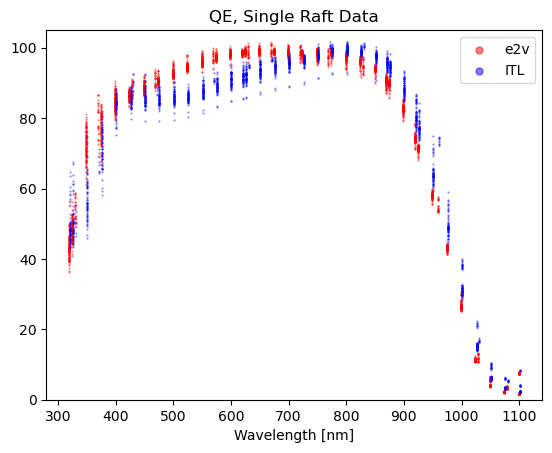

In [15]:
f,ax = plt.subplots(1,1)
itl = (dfall.type=='itl')
e2v = (dfall.type=='e2v')
for i in range(189):
    ptype = det_ptypes[i]
    if ptype=='E2V':
        an_e2v = i
        points_e2v = ax.scatter(dfall['wl'].iloc[i]-1.0,dfall['qe'].iloc[i],marker='.',c='red',s=1.0,alpha=0.5,label='e2v')
    elif ptype=='ITL':
        an_itl = i
        points_itl = ax.scatter(dfall['wl'].iloc[i]+1.0,dfall['qe'].iloc[i],marker='.',c='blue',s=1.0,alpha=0.5,label='ITL')

                
        
ax.set_xlabel('Wavelength [nm]')
ax.set_ylim(0.,105.)
ax.set_title('QE, Single Raft Data')

handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[an_e2v],handles[an_itl]], [labels[an_e2v],labels[an_itl]],markerscale=10.)

#ax.legend(markerscale=10.)